In [5]:
import itertools
import sys
sys.path.append('../src/')

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import bartlett, kendalltau, pearsonr, shapiro, spearmanr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.gofplots import qqplot
from tqdm.notebook import tqdm

from setup.database import db_con
from model.features import calculate_corr, get_levels, normalise_levels, ingest_corr_df

/home/jovyan/conda-envs/sensor/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [6]:
db = db_con()

In [8]:
sorted(db.list_collection_names())

['OLD_WESSEX-WATER_BATH_CSO_SPS_INFO',
 'OLD_WESSEX-WATER_BATH_CSO_SPS_LOCATIONS',
 'OLD_WESSEX-WATER_BATH_CSO_SPS_LOCATIONS_WITHLATLONS',
 'OLD_WESSEX-WATER_BATH_SALTFORD-WRC_FLOW_DATA',
 'OLD_WESSEX-WATER_BATH_SPS_FLOW_DATA',
 'OLD_WESSEX-WATER_CSO_RAINHISTORY',
 'OLD_WESSEX-WATER_WASTE_B_NUMBERS_RUN-STOP',
 'OLD_WESSEX-WATER_WASTE_E_NUMBERS_EDM_LEVEL',
 'WESSEX_B_Numbers_Apr_2017_Raw',
 'WESSEX_B_Numbers_Apr_2019_Raw',
 'WESSEX_CSO_EDM_INFO',
 'WESSEX_E_Numbers_Apr_2017_15Min_Mean',
 'WESSEX_E_Numbers_Apr_2017_60Min_Mean',
 'WESSEX_E_Numbers_Apr_2017_Raw',
 'WESSEX_E_Numbers_Apr_2019_15Min_Max',
 'WESSEX_E_Numbers_Apr_2019_15Min_Mean',
 'WESSEX_E_Numbers_Apr_2019_5Min_Max',
 'WESSEX_E_Numbers_Apr_2019_60Min_Max',
 'WESSEX_E_Numbers_Apr_2019_60Min_Mean',
 'WESSEX_E_Numbers_Apr_2019_60Min_Mean_Prophet_Predictions',
 'WESSEX_E_Numbers_Apr_2019_60Min_Processed',
 'WESSEX_E_Numbers_Apr_2019_Pivot',
 'WESSEX_E_Numbers_Apr_2019_Raw',
 'WESSEX_Incidents',
 'WESSEX_Models',
 'WESSEX_Rain_Apr

In [14]:
from dimensionops_helpers.server_request_handler import ServerRequestHandler
from pymongo import MongoClient


test = ServerRequestHandler()
db_uri = test.get_mongo_secret()["mongoDbTenantSettings"][
    "tenantUserConnectionString"
].replace("/?", "?")
client = MongoClient(db_uri)
db = client["cd_metwessexcso"]

InvalidURI: Bad database name "/atlas-prod-pl-0"

In [2]:
def tsplot(y, title, lags=None, figsize=(18,10)):
    """
    Examine patterns of ACF and PACF, along with time series plot and histogram
    """
    fig = plt.figure(figsize=figsize)
    layout=(2,2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=14, fontweight='bold')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

# Ingestion

In [3]:
# ingest_corr_df(
#     resample_time="60m",
#     difference=True,
#     scaler_method="standard",
#     calculate_dtw=False,
#     output_collection="kk_sensor_correlation_60m"
# )

Dataframe generated.
Ingestion into kk_sensor_correlation_60m complete.


In [4]:
# ingest_corr_df(
#     resample_time="15m",
#     difference=True,
#     scaler_method="standard",
#     calculate_dtw=False,
#     output_collection="kk_sensor_correlation_15m"
# )

Dataframe generated.
Ingestion into kk_sensor_correlation_15m complete.


# EDA

In [6]:
df = get_levels("60m")
df_standard = normalise_levels(df, "standard")
df_diff = df.diff().dropna()
df_diff_standard = normalise_levels(df_diff, "standard")

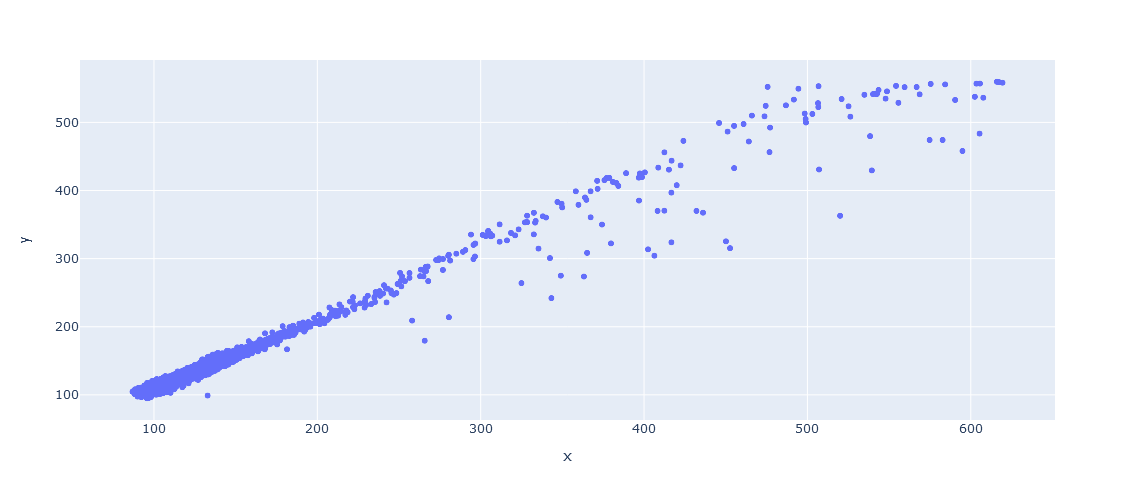

In [8]:
fig = px.scatter(x=df['16067'], y=df['16068'])
fig.update_layout(height=500, width=500)
fig.show()

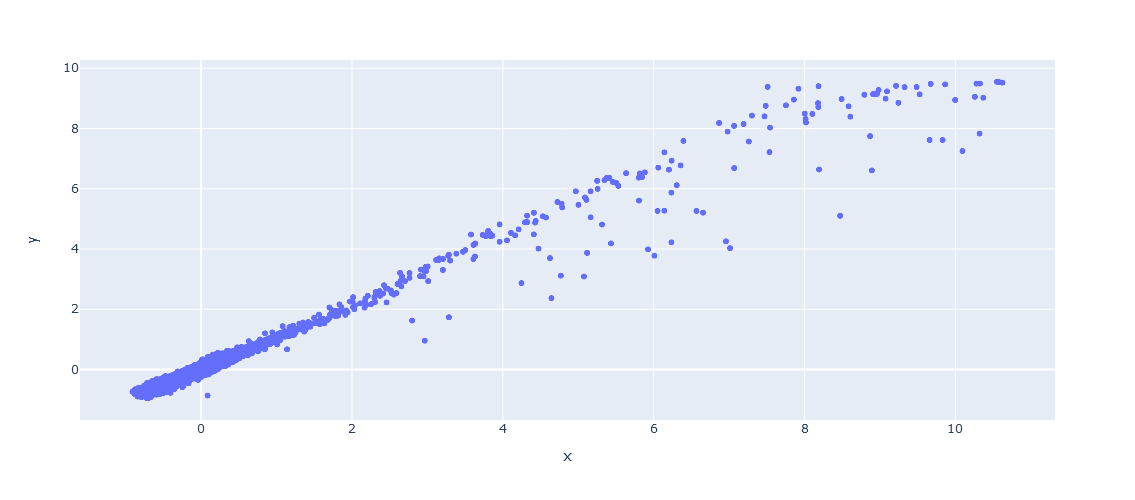

In [9]:
fig = px.scatter(x=df_standard['16067'], y=df_standard['16068'])
fig.update_layout(height=500, width=500)
fig.show()

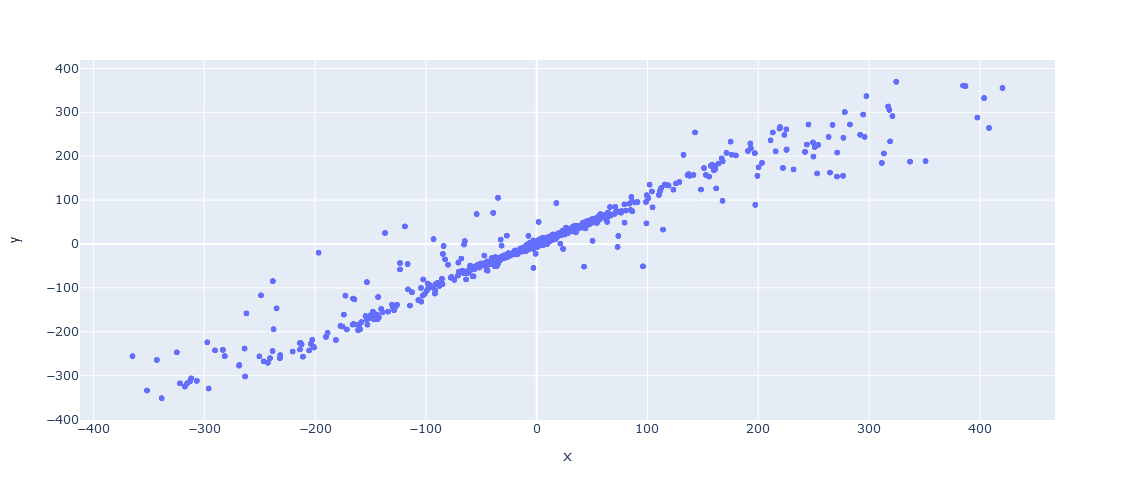

In [10]:
fig = px.scatter(x=df_diff['16067'], y=df_diff['16068'])
fig.update_layout(height=500, width=500)
fig.show()

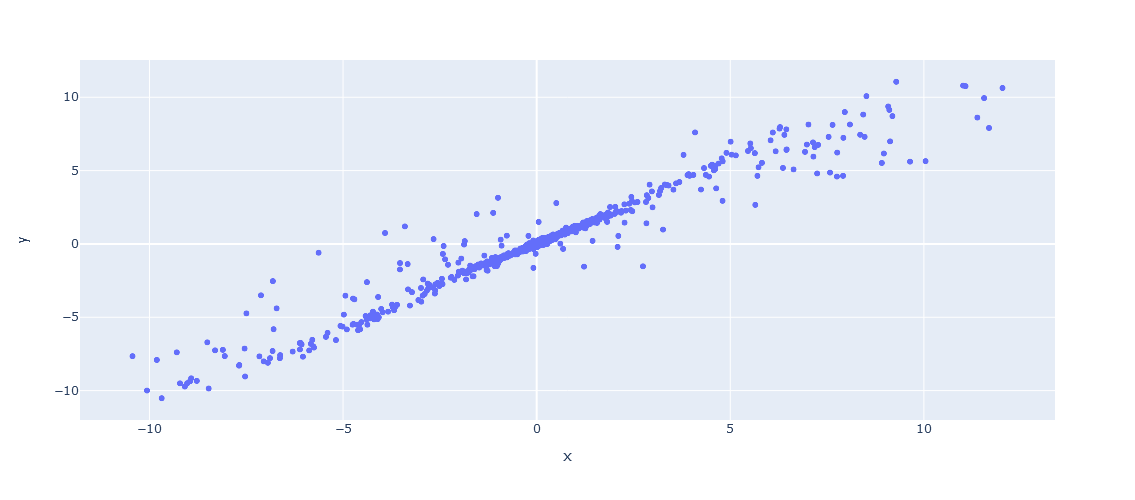

In [11]:
fig = px.scatter(x=df_diff_standard['16067'], y=df_diff_standard['16068'])
fig.update_layout(height=500, width=500)
fig.show()

# Pearson tests

- https://statistics.laerd.com/spss-tutorials/pearsons-product-moment-correlation-using-spss-statistics.php
- https://helpfulstats.com/assumptions-correlation/

# Normality

/home/jovyan/conda-envs/sensor_app/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



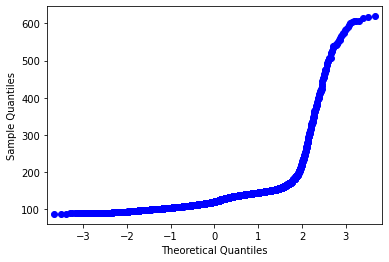

In [58]:
fig = qqplot(df['16067'])

/home/jovyan/conda-envs/sensor_app/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



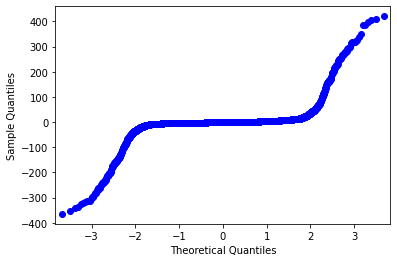

In [59]:
fig = qqplot(df_diff['16067'])

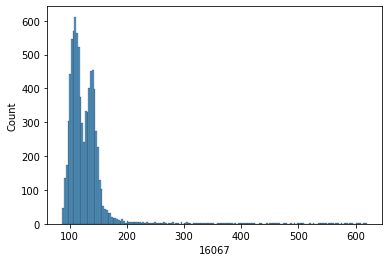

In [68]:
fig = sns.histplot(df['16067'])

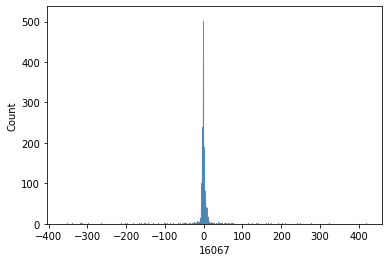

In [67]:
fig = sns.histplot(df_diff['16067'])

# Homoscedascity

In [81]:
print(bartlett(df['16067'], df['16068']))
print(bartlett(df_standard['16067'], df_standard['16068']))
print("")
print(bartlett(df_diff['16067'], df_diff['16068']))
print(bartlett(df_diff_standard['16067'], df_diff_standard['16068']))

BartlettResult(statistic=15.56684054674653, pvalue=7.96390952643467e-05)
BartlettResult(statistic=-1.8806068010706364e-12, pvalue=1.0)

BartlettResult(statistic=16.886677111310007, pvalue=3.967911261995436e-05)
BartlettResult(statistic=1.8803847564680318e-12, pvalue=0.9999989058838655)


# Autocorrelation

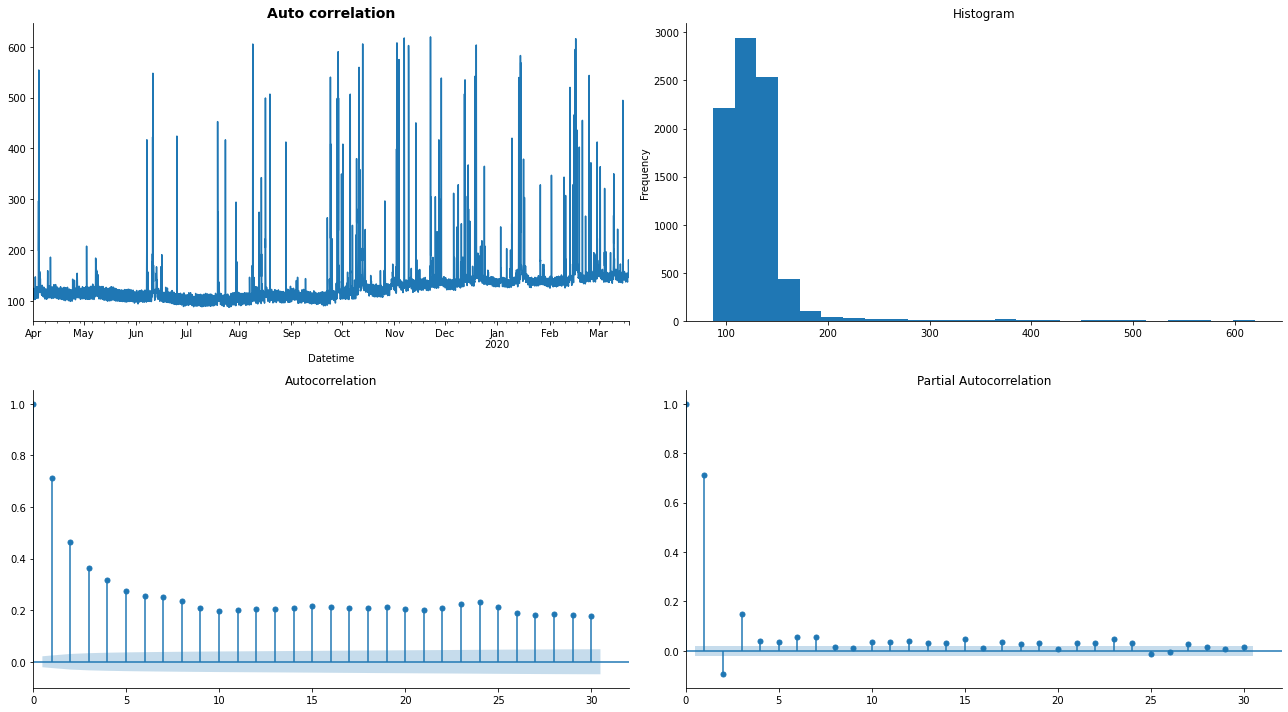

In [79]:
fig = tsplot(df['16067'], "Auto correlation", lags=30)

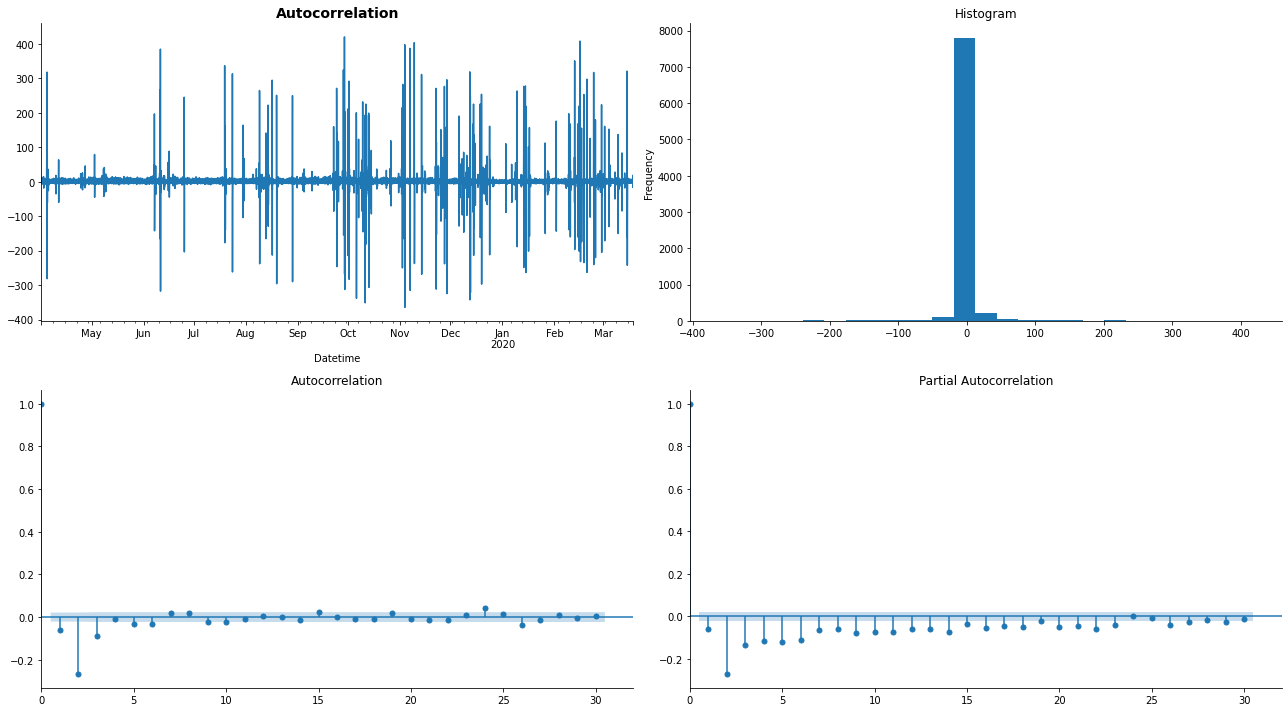

In [82]:
fig = tsplot(df_diff['16067'], "Autocorrelation", lags=30)

In [85]:
df_diff_diff = df_diff.diff().dropna()

In [86]:
df_diff_diff['16067']

Datetime
2019-04-01 02:00:00     0.131889
2019-04-01 03:00:00     0.220991
2019-04-01 04:00:00     2.063818
2019-04-01 05:00:00     2.266993
2019-04-01 06:00:00     8.312304
                         ...    
2020-03-18 19:00:00     4.277344
2020-03-18 20:00:00   -34.607275
2020-03-18 21:00:00    12.183301
2020-03-18 22:00:00    -0.285156
2020-03-18 23:00:00    -4.177539
Name: 16067, Length: 8470, dtype: float64

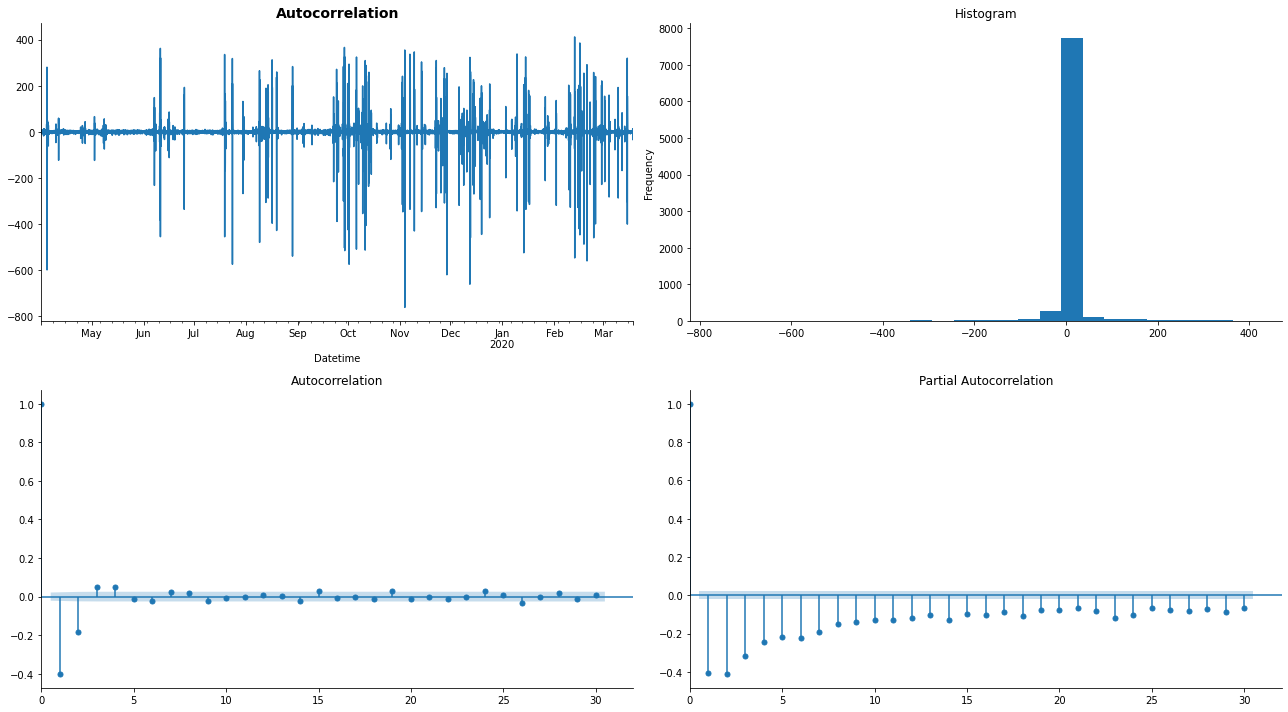

In [87]:
fig = tsplot(df_diff_diff['16067'], "Autocorrelation", lags=30)